In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

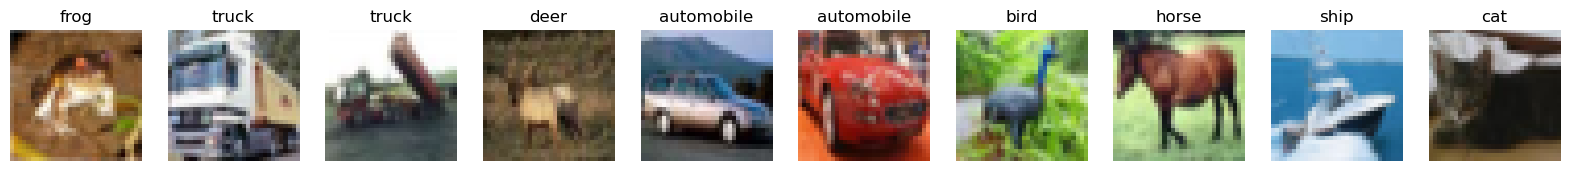

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = 'cifar-10-python/cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

# Load one batch for demonstration (e.g., data_batch_1)
batch_1_dict = load_cifar_batch(os.path.join(cifar10_dir, 'data_batch_1'))
train_images = batch_1_dict[b'data']
train_labels = batch_1_dict[b'labels']

# Reshape the images
train_images = train_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images and labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i])
    plt.title(label_names[train_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

In [5]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch('cifar_test_nolabel.pkl')

# Extract images 
images = cifar10_batch[b'data']
# Unlike the train images you are not required to reshape to (number of images, width, height, channels) 
# as the test data is already in (N x W x H x C) format

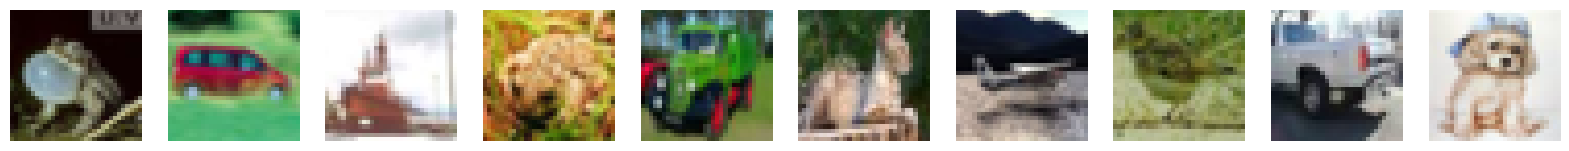

In [7]:
# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

# Import things we need for this project

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F

## doing transform by normalizing.

In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

Import test and traning set.

In [24]:
trainset = torchvision.datasets.CIFAR10(root='cifar-10-python', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='cifar-10-python', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# code is base on this website Implementing ResNet in Pytorch from Scratch
https://www.kaggle.com/code/shakhrulsiam/implementing-resnet-in-pytorch-from-scratch
and also the webside you provide in PDF file :https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
didnt use any thing in the bottleneck section, cause I think maybe it is not nececcry to use anything deepper than 50 layer in 32 by 32 image.

and also referenced this notebook for understanding resnet 
https://github.com/yacineMahdid/deep-learning-model-explained/blob/main/resnet/README.md

In [36]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=5, stride=stride, padding=2, bias=False)#5 by 5 but have 2 padding.(modified the original design. which was 3 by 3 kernel.)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


Modified C from 64 -> 128->256-> 512 to 32->64->128->192
Modify F from 3 by 3 to 5 by 5

In [39]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32# 32 channel

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5,
                               stride=1, padding=2, bias=False)#32channel,modified from 3 by 3 to 5 by 5, and add padding because of this from 1 to 2.
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)# down size from 64 to 32
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 96, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
        self.linear = nn.Linear(128*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [41]:
def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

In [49]:
model = ResNet34()
model = model.to(device)

In [51]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params / 1e6:.2f}M")

from torchsummary import summary
summary(model, input_size=(3, 32, 32))

Total trainable parameters: 4.01M
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,400
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]          25,600
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]          25,600
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]          25,600
     

In [18]:
model = ResNet34()
model = model.to(device)

following code is modified from https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30 #use adam to get quick answer at 1st
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []# used for save training data
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # calculate train acc
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # testing
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # calculate test acc
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.005, momentum = 0.9)#then switch to SGD, which is better than using adam after long training
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=5)

num_epochswarmup = 10
for epoch in range(num_epochswarmup):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # calculate train acc
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    warmup_scheduler.step()
    # testing
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # calculate test acc
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"EpochSGD {epoch+1}/{num_epochswarmup} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005, alpha=0.99)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

num_epochs_rmsprop = 15
for epoch in range(num_epochs_rmsprop):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # calculate train acc
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    scheduler.step()
    # testing
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # calculate test acc
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    
    print(f"EpochRMS {epoch+1}/{num_epochs_rmsprop} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")


Epoch 1/30 | Train Loss: 0.4919 | Train Acc: 83.03% | Test Loss: 0.6405 | Test Acc: 78.55%
Epoch 2/30 | Train Loss: 0.4003 | Train Acc: 86.11% | Test Loss: 0.5719 | Test Acc: 80.83%
Epoch 3/30 | Train Loss: 0.3280 | Train Acc: 88.56% | Test Loss: 0.5403 | Test Acc: 82.49%
Epoch 4/30 | Train Loss: 0.2616 | Train Acc: 90.94% | Test Loss: 0.6367 | Test Acc: 79.96%
Epoch 5/30 | Train Loss: 0.2041 | Train Acc: 92.85% | Test Loss: 0.6025 | Test Acc: 82.20%
Epoch 6/30 | Train Loss: 0.1523 | Train Acc: 94.47% | Test Loss: 0.6265 | Test Acc: 82.35%
Epoch 7/30 | Train Loss: 0.1261 | Train Acc: 95.53% | Test Loss: 0.7276 | Test Acc: 81.29%
Epoch 8/30 | Train Loss: 0.0934 | Train Acc: 96.75% | Test Loss: 0.7806 | Test Acc: 81.60%
Epoch 9/30 | Train Loss: 0.0847 | Train Acc: 97.06% | Test Loss: 0.7580 | Test Acc: 81.82%
Epoch 10/30 | Train Loss: 0.0774 | Train Acc: 97.27% | Test Loss: 0.7723 | Test Acc: 82.38%
Epoch 11/30 | Train Loss: 0.0652 | Train Acc: 97.70% | Test Loss: 0.8585 | Test Acc: 81.1

drawing plot with help from chat-gpt

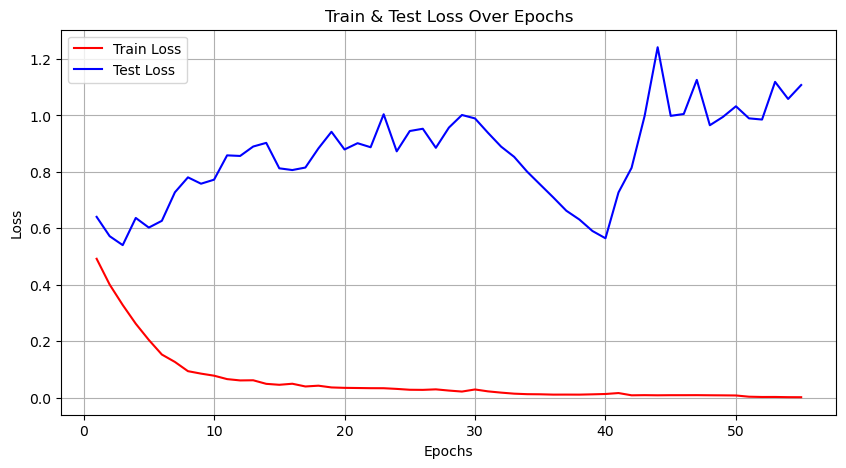

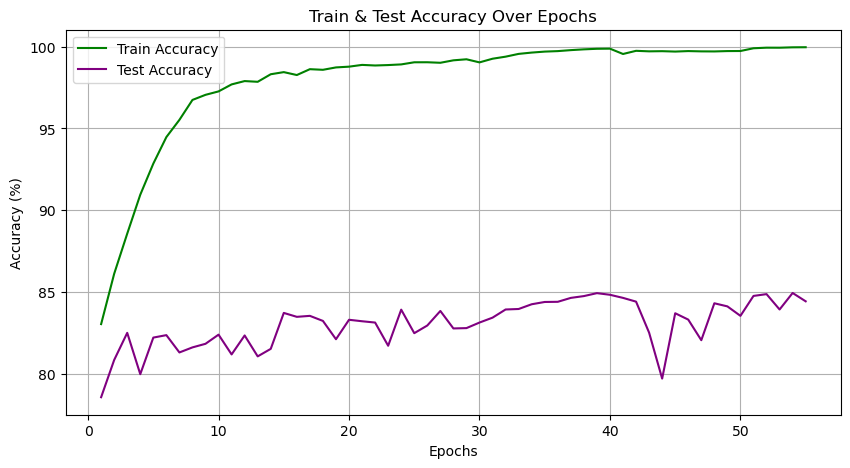

In [68]:
import matplotlib.pyplot as plt

# loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='red')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train & Test Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

#  Accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train & Test Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [70]:
import pickle

with open("cifar_test_nolabel.pkl", "rb") as f:
    test_data = pickle.load(f)



In [72]:
import pandas as pd
import torch
import torchvision.transforms as transforms
test_images = test_data[b'data']
test_ids = test_data[b'ids'] 

test_transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

test_dataset = [(test_transform(img),) for img in test_images]
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

model.eval()

predictions = []
with torch.no_grad():
    for batch in test_loader:
        images = batch[0].to(device)
        outputs = model(images) 
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

submission_df = pd.DataFrame({"ID": test_ids, "Labels": predictions})
submission_df.to_csv("submission.csv", index=False)
print("`submission.csv` generate success")



`submission.csv` generate success
